In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Python Pckages
import random
import string
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt

# ML Packages
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# ML Classifiers
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Deep ML Packages
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dense, Activation, Dropout, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

# ML Metrics
from sklearn.metrics import accuracy_score

In [3]:
removing_characters = list(string.punctuation+'0123456789')
def data_preprocessing(df):
  # Removing NaN Data
  df = df.dropna()

  # Seperating Male Indices and Female Indices
  male_df = []
  female_df = []
  for i in range(df.shape[0]):
    if df.iloc[i, 1] == 'male':
      male_df.append(i)
    elif df.iloc[i, 1] == 'female':
      female_df.append(i)
    df.iloc[i, 0] = str(df.iloc[i, 0]).lower()
    # Removing Special Characters and Digits
    temp = ''
    for char in df.iloc[i, 0]:
      if char not in removing_characters:
        temp += char
    df.iloc[i, 0] = temp
    
  # Creating New Dataset where Number of Male == Number of Female
  sampled_indices = list(random.sample(male_df, len(female_df))) + female_df
  sampled_df = df.iloc[sampled_indices, :]

  for i in range(sampled_df.shape[0]):
    if sampled_df.iloc[i, 1] == "male":
      sampled_df.iloc[i, 1] = "M"
    else:
      sampled_df.iloc[i, 1] = "F"
  
  sampled_df = sampled_df.sample(frac=1)

  return sampled_df

In [4]:
# Load our data
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Filtered_Dataset.csv")
df.head()

,CUSTOMER_NAME,GENDER
0,Md. Jamal,male
1,Beplob Chakrabarti,male
2,Mohammed Amran,male
3,Samim Ahmed,male
4,Md. Mamunor Rashid,male


In [5]:
df = data_preprocessing(df)
df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:

,CUSTOMER_NAME,GENDER
6887,mina begum,F
1588,mst sur banu,F
10057,kiran shushi chakma,F
5520,md shohidul islam sagor,M
348,nargis akter,F


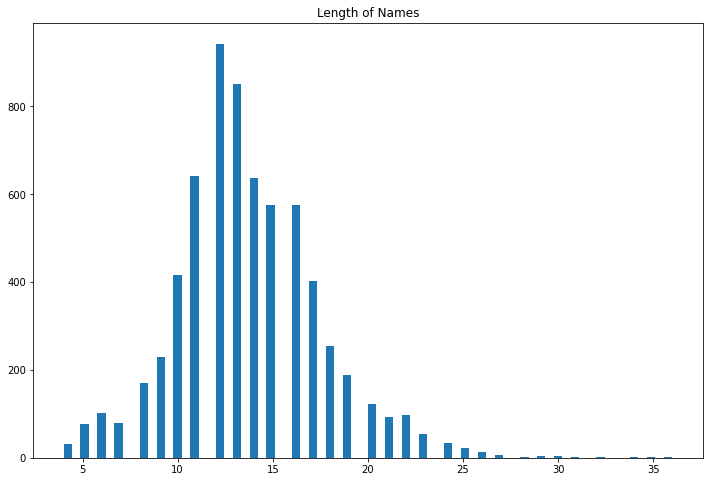

In [6]:
customer_names = df['CUSTOMER_NAME'].apply(lambda x: x.lower())
gender = df['GENDER']
plt.figure(figsize=(12,8))
plt.hist([len(name) for name in customer_names], bins=72)
plt.title("Length of Names")
plt.show()

In [7]:
print("Male : " + str(sum(gender=='M')))
print("Female : " + str(sum(gender=='F')))

Male : 3316
Female : 3316


In [8]:
vocabulary = set(' '.join([str(i) for i in customer_names]))
vocabulary.add('END')
len_vocabulary = len(vocabulary)

In [9]:
print(len_vocabulary)
print(vocabulary)

28
{'j', 'b', 'END', 'q', 'p', 'u', 'g', 's', 'y', 'l', 'e', 'i', 'o', 't', 'h', 'r', 'k', 'd', 'v', 'w', 'n', 'x', 'z', 'm', 'c', 'f', ' ', 'a'}


In [10]:
char_index = dict((c, i) for i, c in enumerate(vocabulary))
char_index

{' ': 26,
 'END': 2,
 'a': 27,
 'b': 1,
 'c': 24,
 'd': 17,
 'e': 10,
 'f': 25,
 'g': 6,
 'h': 14,
 'i': 11,
 'j': 0,
 'k': 16,
 'l': 9,
 'm': 23,
 'n': 20,
 'o': 12,
 'p': 4,
 'q': 3,
 'r': 15,
 's': 7,
 't': 13,
 'u': 5,
 'v': 18,
 'w': 19,
 'x': 21,
 'y': 8,
 'z': 22}

In [11]:
maxlen = 30
labels = 2

In [12]:
X = []
y = []

# Builds an empty line with a 1 at the index of character
def set_flag(i):
    temp = np.zeros(len_vocabulary);
    temp[i] = 1
    return list(temp)

# Truncate names and create the matrix
def prepare_X(X):
    new_list = []
    trunc_train_name = [str(i)[0:maxlen] for i in X]

    for i in trunc_train_name:
        tmp = [set_flag(char_index[j]) for j in str(i)]
        for k in range(0,maxlen - len(str(i))):
            tmp.append(set_flag(char_index["END"]))
        new_list.append(tmp)

    return new_list


X = prepare_X(customer_names.values)

# Label Encoding of y
def prepare_y(y):
    new_list = []
    for i in y:
        if i == 'M':
            new_list.append([1,0])
        else:
            new_list.append([0,1])

    return new_list

y = prepare_y(gender)

Streaming output truncated to the last 5000 lines.
badsha
ranjit chandra pal
md jamal hossain
shirina begum
sahnaz farzana
pronab banerjee
swapan kumar nath
samana khatun
rajia
md abdul haq sab
md ranju mia
rangbay mogini
md mostofa tafader
sultana rajia raju
somsun nasa
mst lutfa
mst deloyara bibi
saddam hossain sagar
mominul islam
syed md baha uddin
md maniruzzaman
jahangir hushen masum
md rana sharif
shohel mahamud
shah alam somrat
sabita rani davy
hanufa begum
md monir
md hridoy miah
monoara begum
reziya begum
rajia bagem
asia khatun
mst zahanara begum
tajnahar
md momin ali
asma
md sahabuddin
delewar hosen
anuwar hossen
munjurul  hoque
eyasmin akter
radwan ahmed
rehena akther
charu datta
raju barua
liton chandra das
banita chakma
fahima begum
mrs silpi akter
jahan ara begum
md sujan khalifa
baby akter
shak forid
alok kumar seel
bishonat uraw
rita chakma
md mahmud islam
md rubel ahmed
md abdur rahim
milon kanti shil
lutfur nesa
sarif ahmmed
mst anzuara begum
omar faroque
md abass ud

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [14]:
model = Sequential()
model.add(Bidirectional(LSTM(512, return_sequences=True), 
                        backward_layer=LSTM(512, return_sequences=True, go_backwards=True), 
                        input_shape=(maxlen,len_vocabulary)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(512)))
model.add(Dropout(0.2))
model.add(Dense(2, activity_regularizer=l2(0.002)))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

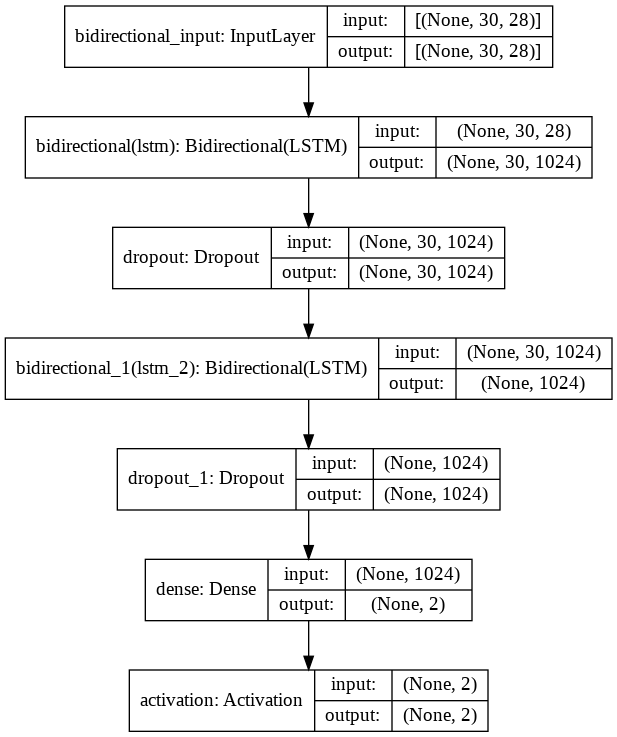

In [15]:
plot_model(model, to_file='/content/drive/MyDrive/Colab Notebooks/model.png', show_shapes=True, expand_nested=True)

In [16]:
callback = EarlyStopping(monitor='val_loss', patience=5)
mc = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/model.h5', monitor='val_loss', mode='min', verbose=1)
reduce_lr_acc = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, verbose=1, min_delta=1e-4, mode='max')

In [17]:
batch_size = 256
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=35, 
                    verbose=1, validation_data =(X_test, y_test), 
                    callbacks=[callback, mc, reduce_lr_acc])

Epoch 1/35
19/19 [==============================] - 15s 463ms/step - loss: 0.6840 - accuracy: 0.6076 - val_loss: 0.5000 - val_accuracy: 0.8116

Epoch 00001: saving model to /content/drive/MyDrive/Colab Notebooks/model.h5
Epoch 2/35
19/19 [==============================] - 3s 135ms/step - loss: 0.4496 - accuracy: 0.8134 - val_loss: 0.3271 - val_accuracy: 0.8578

Epoch 00002: saving model to /content/drive/MyDrive/Colab Notebooks/model.h5
Epoch 3/35
19/19 [==============================] - 3s 137ms/step - loss: 0.3279 - accuracy: 0.8592 - val_loss: 0.2551 - val_accuracy: 0.8985

Epoch 00003: saving model to /content/drive/MyDrive/Colab Notebooks/model.h5
Epoch 4/35
19/19 [==============================] - 3s 135ms/step - loss: 0.2742 - accuracy: 0.8842 - val_loss: 0.2486 - val_accuracy: 0.9020

Epoch 00004: saving model to /content/drive/MyDrive/Colab Notebooks/model.h5
Epoch 5/35
19/19 [==============================] - 3s 136ms/step - loss: 0.2629 - accuracy: 0.8855 - val_loss: 0.2584 

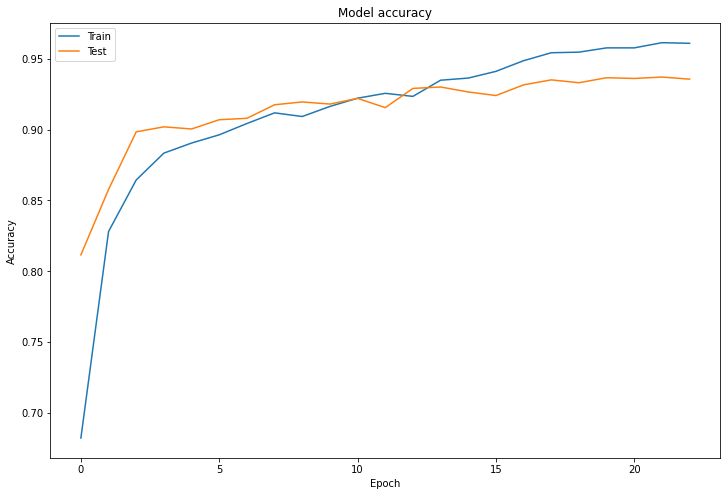

In [18]:
plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [19]:
test_names = ["Rayhan Rashid",
              "Rani",
              "Afsana Yeasmin Mili",
              "Rayhana",
              "Md. Zahid Hossain Khan", 
              "Shahriar Haque", 
              "Ashique Jubayer",
              "Nowsin", 
              "Shajedul Islam",
              "Saif Ahmed Anik", 
              "Toriqul Islam",
              "Afrina Yeasmin Mithila",
              "MD. Khalid Hossain Khan",
              "Md. Faruque Hossain Khan",
              "Md. Abdul Aziz Khan",
              "Samsun Nahar",
              "Farhana Sharmin",
              "Mahbub Azam",
              "Roni Hauladar", 
              "Chowdhuri Mofizur Rahman",
              "Sajid Ahmed",
              "Swakkhar Swatabda",
              "Sabila Nowshin",
              "Rifat Jabin",
              "Tithi",
              "Tanvir Rashid",
              "Kamrul Islam Tushar",
              "Sahanaj",
              "Suma Akhter",
              "Nishat Fariha",
              "Faiza Alam",
              "Ripon Khan",
              "Ridita Afrin"]

In [20]:
for i in range(len(test_names)):
  temp = ''
  for char in test_names[i]:
    if char not in removing_characters:
      temp += char
  test_names[i] = temp
test_names

['Rayhan Rashid',
 'Rani',
 'Afsana Yeasmin Mili',
 'Rayhana',
 'Md Zahid Hossain Khan',
 'Shahriar Haque',
 'Ashique Jubayer',
 'Nowsin',
 'Shajedul Islam',
 'Saif Ahmed Anik',
 'Toriqul Islam',
 'Afrina Yeasmin Mithila',
 'MD Khalid Hossain Khan',
 'Md Faruque Hossain Khan',
 'Md Abdul Aziz Khan',
 'Samsun Nahar',
 'Farhana Sharmin',
 'Mahbub Azam',
 'Roni Hauladar',
 'Chowdhuri Mofizur Rahman',
 'Sajid Ahmed',
 'Swakkhar Swatabda',
 'Sabila Nowshin',
 'Rifat Jabin',
 'Tithi',
 'Tanvir Rashid',
 'Kamrul Islam Tushar',
 'Sahanaj',
 'Suma Akhter',
 'Nishat Fariha',
 'Faiza Alam',
 'Ripon Khan',
 'Ridita Afrin']

In [21]:
X_pred = prepare_X([name.lower() for name in test_names])
predictions = model.predict(X_pred)
predictions

rayhan rashid
rani
afsana yeasmin mili
rayhana
md zahid hossain khan
shahriar haque
ashique jubayer
nowsin
shajedul islam
saif ahmed anik
toriqul islam
afrina yeasmin mithila
md khalid hossain khan
md faruque hossain khan
md abdul aziz khan
samsun nahar
farhana sharmin
mahbub azam
roni hauladar
chowdhuri mofizur rahman
sajid ahmed
swakkhar swatabda
sabila nowshin
rifat jabin
tithi
tanvir rashid
kamrul islam tushar
sahanaj
suma akhter
nishat fariha
faiza alam
ripon khan
ridita afrin


array([[0.7642251 , 0.2357749 ],
       [0.15659443, 0.8434056 ],
       [0.00508965, 0.9949104 ],
       [0.02139823, 0.9786018 ],
       [0.9821817 , 0.0178183 ],
       [0.1803471 , 0.8196529 ],
       [0.9226098 , 0.07739026],
       [0.22071835, 0.7792817 ],
       [0.98560613, 0.01439389],
       [0.97166383, 0.02833614],
       [0.99055326, 0.00944674],
       [0.00945755, 0.9905425 ],
       [0.9933264 , 0.00667353],
       [0.9896986 , 0.01030147],
       [0.98437667, 0.01562331],
       [0.0353878 , 0.9646122 ],
       [0.28247112, 0.7175289 ],
       [0.97487056, 0.02512943],
       [0.03350681, 0.9664932 ],
       [0.8500199 , 0.14998008],
       [0.97333103, 0.02666896],
       [0.5444996 , 0.45550042],
       [0.52725106, 0.47274894],
       [0.31646907, 0.683531  ],
       [0.1139829 , 0.8860171 ],
       [0.68430066, 0.3156993 ],
       [0.9825022 , 0.01749777],
       [0.4488766 , 0.5511234 ],
       [0.00742117, 0.9925788 ],
       [0.40968376, 0.5903163 ],
       [0.

In [22]:
test_prediction = ['M' if np.argmax(prediction) == 0 else 'F' for prediction in predictions]

In [23]:
test_table = []
for i in range(len(test_names)):
  test_table.append([test_names[i], test_prediction[i]])
print("\n\n## Test Names Result ##\n")
print(tabulate(test_table, headers= ['Name', 'Gender']))



## Test Names Result ##

Name                      Gender
------------------------  --------
Rayhan Rashid             M
Rani                      F
Afsana Yeasmin Mili       F
Rayhana                   F
Md Zahid Hossain Khan     M
Shahriar Haque            F
Ashique Jubayer           M
Nowsin                    F
Shajedul Islam            M
Saif Ahmed Anik           M
Toriqul Islam             M
Afrina Yeasmin Mithila    F
MD Khalid Hossain Khan    M
Md Faruque Hossain Khan   M
Md Abdul Aziz Khan        M
Samsun Nahar              F
Farhana Sharmin           F
Mahbub Azam               M
Roni Hauladar             F
Chowdhuri Mofizur Rahman  M
Sajid Ahmed               M
Swakkhar Swatabda         M
Sabila Nowshin            M
Rifat Jabin               F
Tithi                     F
Tanvir Rashid             M
Kamrul Islam Tushar       M
Sahanaj                   F
Suma Akhter               F
Nishat Fariha             F
Faiza Alam                F
Ripon Khan                M
Ridita Af

In [24]:
##### 50K Test Data #####

In [25]:
# Load test data
test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Test_Dataset.csv")
test_df.head()

,CUSTOMER_NAME,GENDER
0,subal banik,Male
1,MD KAMAL HOSSEN,Male
2,mafia,Female
3,amran hosen gazi,Male
4,MD SATTAR,Male


In [26]:
print(test_df.shape)
test_df = test_df.dropna()
print(test_df.shape)

(50000, 2)
(47864, 2)


In [27]:
for i in range(test_df.shape[0]):
  temp = ''
  for char in test_df.iloc[i, 0]:
    if char not in removing_characters:
      temp += char
  test_df.iloc[i, 0] = temp
test_df.head()

,CUSTOMER_NAME,GENDER
0,subal banik,Male
1,MD KAMAL HOSSEN,Male
2,mafia,Female
3,amran hosen gazi,Male
4,MD SATTAR,Male


In [28]:
for i in range(test_df.shape[0]):
  test_df.iloc[i, 0], test_df.iloc[i, 1] = str(test_df.iloc[i, 0]).lower(), str(test_df.iloc[i, 1]).lower()
  if test_df.iloc[i, 1] == 'male':
    test_df.iloc[i, 1] = 'M'
  else:
    test_df.iloc[i, 1] = 'F'
test_df.head()

,CUSTOMER_NAME,GENDER
0,subal banik,M
1,md kamal hossen,M
2,mafia,F
3,amran hosen gazi,M
4,md sattar,M


In [29]:
test_X, test_y = list(test_df.iloc[:, 0]), list(test_df.iloc[:, 1])
print(test_X)

['subal banik', 'md kamal hossen', 'mafia', 'amran hosen gazi', 'md sattar', 'dr md badrul hasan', 'jane alom', 'padhip sarkar', 'md basrujjaman rubel', 'md kamrul hasan', 'satara', 'a s m ibrahim kanak', 'md ismial', 'mdabdur razzak', 'israfil hossan edo chowdury', 'abdul dulal', 'fozilat begum', 'md mokhlesur rahman', 'salama katun', 'mrs akhi akter', 'ohah id', 'ranu aktar', 'asma aktar', 'shahanaj', 'sona rika', 'priyodan chandra nath', 'robi alam', 'md anarul hosen', 'mdrubel', 'afrina akter', 'sotis gain', 'narul isalm', 'md deluare hossain', 'md shoriyat ullah', 'md shofikur  rahaman', 'dm rasel', 'khalida begum', 'md amjad', 'maloti rani', 'md atauar rohman', 'jitendro nath saha', 'masura begum', 'mst sumi', 'noyan akter', 'md sadulla bepari', 'arun kanti', 'md mostafizur rahman', 'oli olla minto', 'sabikun nahar', 'md eleyas', 'sayed mohammed hossin', 'manjur hosen', 'hazra begum', 'ab mannan bepari', 'moslem uddin', 'khandaker titu mia', 'bia dhani', 'md abrab', 'md fayzul ha

In [30]:
test_X_pred = prepare_X(test_X)
test_predictions = model.predict(test_X_pred)
test_predictions

Streaming output truncated to the last 5000 lines.
rosiyas begum
biplob roman
gapal chnada
tanjura
s d mehedi hasan
anwer  hossan
abdul hasem mid
bandro ckam
borfhan
mdmofij uddin
hosnear abagume
tapon dastagir
manjri sen
md h elal
md momin buiya
lalon hossan
sk abdul ali
md jahanagua
kaiko chakma
md fazlullah
paipru marma
sahelah ahmed
masreka sultan
md monroal
md kuhub uddin
prodes chakma
kazi kabirul hasan
samul isalm
mozibullah
zannathul ferdosh
laxmi rani vokto
mst sahid khatun
naimsa
abduas shmad
syed mostafizur hossain
lakhi rani chakrabaty
md hak khan
jamor begum
subarna beja
s g m ashif nawshad
panu hosen
md mijaru rahaman
itlan sangma
mst mahmada alam
md shah jahan ali kanb
kahida
nurtaj begum
fm moinul islam
nurul kaisar
ansra marma
sahinur  rohman
nura jannat sharmin
bikas chandra sutradhar
moyhammad shahid uddin eskende
jakir hossain shajib
sawpan chandro mohonto
md rashidul islam rashid
bancharam
khirol gji
md sekender hossen
md sabanur rahman
shekh azharul islam
pritesh 

array([[0.93193614, 0.06806386],
       [0.9973078 , 0.00269226],
       [0.01368361, 0.9863164 ],
       ...,
       [0.9902867 , 0.00971326],
       [0.9898746 , 0.0101254 ],
       [0.0526029 , 0.94739705]], dtype=float32)

In [31]:
final_test_predictions = ['M' if np.argmax(prediction) == 0 else 'F' for prediction in test_predictions]

In [32]:
accuracy = accuracy_score(test_y, final_test_predictions)
print(f"Accuracy : {round(accuracy * 100, 2)}%")

Accuracy : 79.6%


In [33]:
result = pd.DataFrame(list(zip(test_X, test_y, final_test_predictions)), columns=['Name', 'Original Gender', 'Predicted Gender'])
result.to_csv('/content/drive/MyDrive/Colab Notebooks/Result(LSTM).csv', index=False) 